
## Introduction

The **Tea Leaf Disease Dataset** provides a collection of high-quality images aimed at identifying and classifying various diseases in tea leaves. Accurate detection of plant diseases is crucial in agriculture to ensure timely treatment and minimize crop loss. This dataset contains categorized images of tea leaves affected by different types of diseases such as **Anthracnose**, **Algal Leaf**, **Bird Eye Spot**, and others, as well as healthy leaves.

The goal of this notebook is to explore the dataset, perform image preprocessing, and build a robust machine learning model capable of classifying tea leaf diseases from images. The insights gained can assist in developing intelligent agricultural systems and mobile-based diagnosis tools for farmers.


## Tools

In [1]:
!pip install efficientnet_pytorch -q

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 92.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 78.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 43.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 83.5 MB/s eta 0:00:00


In [2]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from collections import defaultdict
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split, Subset
from torchvision import datasets, transforms
from torchvision import models

from sklearn.model_selection import StratifiedShuffleSplit
from efficientnet_pytorch import EfficientNet

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix


## EDA

In [3]:
dataset_dir = '/kaggle/input/identifying-disease-in-tea-leafs/tea sickness dataset'


In [4]:
classes = sorted(os.listdir(dataset_dir))
print(f"Classes found ({len(classes)}): {classes}")

Classes found (8): ['Anthracnose', 'algal leaf', 'bird eye spot', 'brown blight', 'gray light', 'healthy', 'red leaf spot', 'white spot']


In [5]:
image_counts = {cls: len(os.listdir(os.path.join(dataset_dir, cls))) for cls in classes}

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


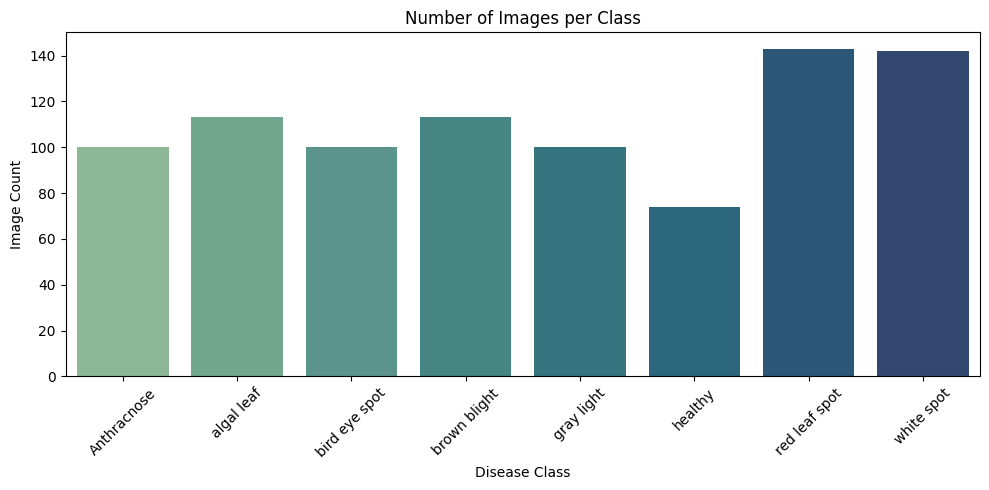

In [6]:
plt.figure(figsize=(10, 5))
sns.barplot(x=list(image_counts.keys()), y=list(image_counts.values()), palette='crest')
plt.title("Number of Images per Class")
plt.xticks(rotation=45)
plt.ylabel("Image Count")
plt.xlabel("Disease Class")
plt.tight_layout()
plt.show()


Show samples from each class.

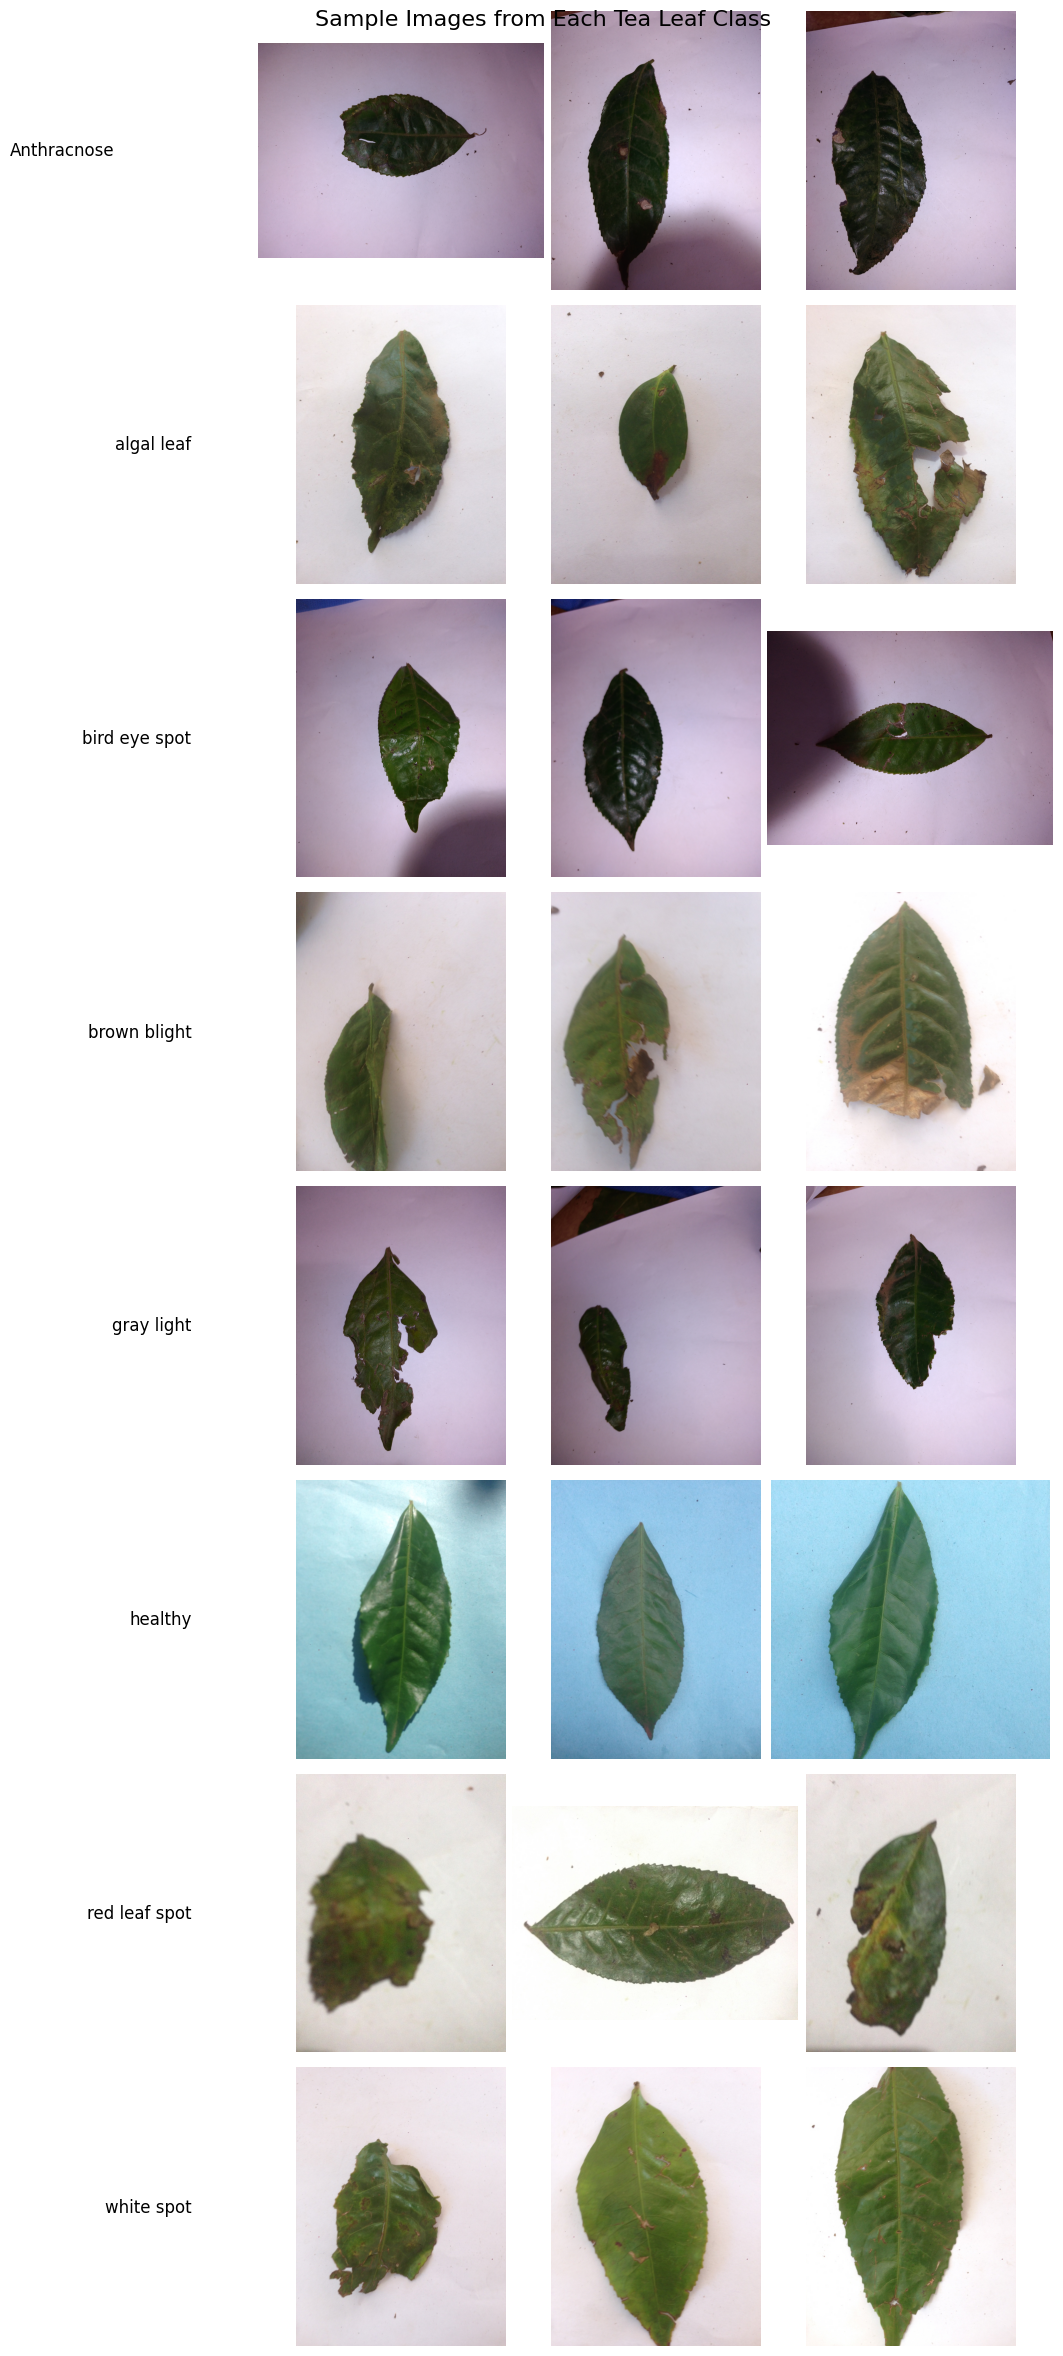

In [7]:
def plot_sample_images(directory, classes, samples_per_class=3):
    plt.figure(figsize=(samples_per_class * 3.5, len(classes) * 3))
    
    for i, cls in enumerate(classes):
        cls_path = os.path.join(directory, cls)
        sample_imgs = random.sample(os.listdir(cls_path), min(samples_per_class, len(os.listdir(cls_path))))
        
        for j, img_name in enumerate(sample_imgs):
            img_path = os.path.join(cls_path, img_name)
            img = Image.open(img_path)
            
            index = i * samples_per_class + j + 1
            plt.subplot(len(classes), samples_per_class, index)
            plt.imshow(img)
            plt.axis('off')
            
            # Add class label as text to the left of the row
            if j == 0:
                plt.text(-0.5, 0.5, cls, fontsize=12, ha='right', va='center', rotation=0, transform=plt.gca().transAxes)

    plt.suptitle("Sample Images from Each Tea Leaf Class", fontsize=16)
    plt.tight_layout()
    plt.show()

plot_sample_images(dataset_dir, classes, samples_per_class=3)


## Data Preproccessing

In [8]:
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])


In [9]:
full_dataset = datasets.ImageFolder(root=dataset_dir)

In [10]:
targets = np.array([label for _, label in full_dataset.imgs])

Split into equal class distrubutions splits (train, val, test)

In [11]:
total_size = len(targets)
train_size = 0.7
val_size = 0.15
test_size = 0.15


In [12]:
sss1 = StratifiedShuffleSplit(n_splits=1, test_size=(val_size + test_size), random_state=42)
train_idx, temp_idx = next(sss1.split(np.zeros(total_size), targets))


In [13]:
temp_targets = targets[temp_idx]
sss2 = StratifiedShuffleSplit(n_splits=1, test_size=0.5, random_state=42)
val_idx_rel, test_idx_rel = next(sss2.split(np.zeros(len(temp_idx)), temp_targets))

In [14]:
val_idx = np.array(temp_idx)[val_idx_rel]
test_idx = np.array(temp_idx)[test_idx_rel]

In [15]:
print(f"Train: {len(train_idx)} | Val: {len(val_idx)} | Test: {len(test_idx)}")


Train: 619 | Val: 133 | Test: 133


In [16]:
# Reload dataset with train transform
dataset_with_train_transform = datasets.ImageFolder(root=dataset_dir, transform=train_transform)
dataset_with_test_transform = datasets.ImageFolder(root=dataset_dir, transform=test_transform)

# Create subsets
train_dataset = Subset(dataset_with_train_transform, train_idx)
val_dataset = Subset(dataset_with_test_transform, val_idx)
test_dataset = Subset(dataset_with_test_transform, test_idx)


In [17]:
train_dataset

In [18]:
BATCH_SIZE = 32

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)


## Model Selection

In [19]:
NUM_CLASSES = 8

In [20]:
model = models.resnet50(pretrained=True)


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 179MB/s]


In [21]:
model.fc = nn.Sequential(
    nn.Dropout(0.4),
    nn.Linear(model.fc.in_features, NUM_CLASSES)
)


In [22]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)


## Model Training

In [23]:

class Trainer:
    def __init__(self, model, train_loader, val_loader, criterion, optimizer, scheduler=None, device='cuda', save_path='best_model.pth'):
        self.model = model.to(device)
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.criterion = criterion
        self.optimizer = optimizer
        self.scheduler = scheduler
        self.device = device
        self.save_path = save_path
        self.best_val_acc = 0.0  # To track the best validation accuracy

    def train(self, num_epochs):
        for epoch in range(num_epochs):
            self.model.train()
            running_loss = 0.0
            correct = 0
            total = 0

            loop = tqdm(self.train_loader, desc=f"Epoch [{epoch+1}/{num_epochs}]", leave=False)
            for inputs, labels in loop:
                inputs, labels = inputs.to(self.device), labels.to(self.device)

                self.optimizer.zero_grad()
                outputs = self.model(inputs)
                loss = self.criterion(outputs, labels)
                loss.backward()
                self.optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                _, predicted = torch.max(outputs, 1)
                correct += (predicted == labels).sum().item()
                total += labels.size(0)

                loop.set_postfix(loss=loss.item(), acc=100 * correct / total)

            epoch_loss = running_loss / total
            epoch_acc = 100. * correct / total
            print(f"\nTrain Epoch {epoch+1}: Loss = {epoch_loss:.4f}, Accuracy = {epoch_acc:.2f}%")

            # Validation after each epoch
            val_acc = self.validate(epoch)

            # Save best model
            if val_acc > self.best_val_acc:
                print(f"New best model found at epoch {epoch+1} with val acc {val_acc:.2f}%. Saving model...")
                self.best_val_acc = val_acc
                torch.save(self.model.state_dict(), self.save_path)

            # Step the scheduler (if provided)
            if self.scheduler:
                self.scheduler.step()

    def validate(self, epoch):
        self.model.eval()
        val_loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad():
            for inputs, labels in self.val_loader:
                inputs, labels = inputs.to(self.device), labels.to(self.device)
                outputs = self.model(inputs)
                loss = self.criterion(outputs, labels)

                val_loss += loss.item() * inputs.size(0)
                _, predicted = torch.max(outputs, 1)
                correct += (predicted == labels).sum().item()
                total += labels.size(0)

        val_loss /= total
        val_acc = 100. * correct / total
        print(f"Validation Epoch {epoch+1}: Loss = {val_loss:.4f}, Accuracy = {val_acc:.2f}%")
        return val_acc  # Return accuracy to compare with best


In [24]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)


In [25]:
trainer = Trainer(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    device=device
)

trainer.train(num_epochs=20)



Train Epoch 1: Loss = 1.4102, Accuracy = 49.27%
Validation Epoch 1: Loss = 0.6524, Accuracy = 77.44%
New best model found at epoch 1 with val acc 77.44%. Saving model...



Train Epoch 2: Loss = 0.5244, Accuracy = 83.68%
Validation Epoch 2: Loss = 0.3708, Accuracy = 87.22%
New best model found at epoch 2 with val acc 87.22%. Saving model...



Train Epoch 3: Loss = 0.2806, Accuracy = 91.76%
Validation Epoch 3: Loss = 0.3842, Accuracy = 85.71%



Train Epoch 4: Loss = 0.2397, Accuracy = 91.28%
Validation Epoch 4: Loss = 0.2979, Accuracy = 87.97%
New best model found at epoch 4 with val acc 87.97%. Saving model...



Train Epoch 5: Loss = 0.1767, Accuracy = 94.02%
Validation Epoch 5: Loss = 0.5178, Accuracy = 78.95%



Train Epoch 6: Loss = 0.1511, Accuracy = 94.99%
Validation Epoch 6: Loss = 0.2593, Accuracy = 88.72%
New best model found at epoch 6 with val acc 88.72%. Saving model...



Train Epoch 7: Loss = 0.0850, Accuracy = 98.06%
Validation Epoch 7: Loss = 0.2406, Accuracy = 91.73%
New best model found at epoch 7 with val acc 91.73%. Saving model...



Train Epoch 8: Loss = 0.0656, Accuracy = 98.06%
Validation Epoch 8: Loss = 0.2222, Accuracy = 92.48%
New best model found at epoch 8 with val acc 92.48%. Saving model...



Train Epoch 9: Loss = 0.0852, Accuracy = 98.06%
Validation Epoch 9: Loss = 0.2121, Accuracy = 92.48%



Train Epoch 10: Loss = 0.0711, Accuracy = 98.22%
Validation Epoch 10: Loss = 0.2154, Accuracy = 92.48%



Train Epoch 11: Loss = 0.0696, Accuracy = 98.71%
Validation Epoch 11: Loss = 0.2176, Accuracy = 93.23%
New best model found at epoch 11 with val acc 93.23%. Saving model...



Train Epoch 12: Loss = 0.0550, Accuracy = 99.35%
Validation Epoch 12: Loss = 0.2084, Accuracy = 93.23%



Train Epoch 13: Loss = 0.0465, Accuracy = 99.19%
Validation Epoch 13: Loss = 0.2053, Accuracy = 93.23%



Train Epoch 14: Loss = 0.0526, Accuracy = 98.71%
Validation Epoch 14: Loss = 0.2083, Accuracy = 92.48%



Train Epoch 15: Loss = 0.0673, Accuracy = 98.87%
Validation Epoch 15: Loss = 0.2178, Accuracy = 93.98%
New best model found at epoch 15 with val acc 93.98%. Saving model...



Train Epoch 16: Loss = 0.0542, Accuracy = 99.35%
Validation Epoch 16: Loss = 0.2065, Accuracy = 93.23%



Train Epoch 17: Loss = 0.0501, Accuracy = 99.19%
Validation Epoch 17: Loss = 0.2061, Accuracy = 93.23%



Train Epoch 18: Loss = 0.0504, Accuracy = 99.35%
Validation Epoch 18: Loss = 0.1999, Accuracy = 93.23%



Train Epoch 19: Loss = 0.0530, Accuracy = 99.19%
Validation Epoch 19: Loss = 0.2092, Accuracy = 93.23%



Train Epoch 20: Loss = 0.0569, Accuracy = 98.87%
Validation Epoch 20: Loss = 0.2076, Accuracy = 92.48%


## Evaluate The Model

In [26]:
class Evaluator:
    def __init__(self, model, dataloader, device, class_names=None):
        self.model = model
        self.dataloader = dataloader
        self.device = device
        self.class_names = class_names  # Optional list of class labels

    def evaluate(self):
        self.model.eval()
        all_preds = []
        all_labels = []

        with torch.no_grad():
            for inputs, labels in self.dataloader:
                inputs = inputs.to(self.device)
                labels = labels.to(self.device)

                outputs = self.model(inputs)
                _, preds = torch.max(outputs, 1)

                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

        # Compute metrics
        acc = accuracy_score(all_labels, all_preds)
        prec = precision_score(all_labels, all_preds, average='weighted', zero_division=0)
        rec = recall_score(all_labels, all_preds, average='weighted', zero_division=0)
        f1 = f1_score(all_labels, all_preds, average='weighted', zero_division=0)

        print(f"Accuracy:  {acc:.4f}")
        print(f"Precision: {prec:.4f}")
        print(f"Recall:    {rec:.4f}")
        print(f"F1 Score:  {f1:.4f}")

        # Confusion Matrix
        cm = confusion_matrix(all_labels, all_preds)
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                    xticklabels=self.class_names if self.class_names else None,
                    yticklabels=self.class_names if self.class_names else None)
        plt.title("Confusion Matrix")
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.tight_layout()
        plt.show()

        return {
            "accuracy": acc,
            "precision": prec,
            "recall": rec,
            "f1_score": f1,
            "confusion_matrix": cm
        }


In [27]:
class_names = ['Anthracnose', 'algal leaf', 'bird eye spot', 'brown blight', 'gray light', 'healthy', 'red leaf spot', 'white spot']

Accuracy:  0.9248
Precision: 0.9264
Recall:    0.9248
F1 Score:  0.9248


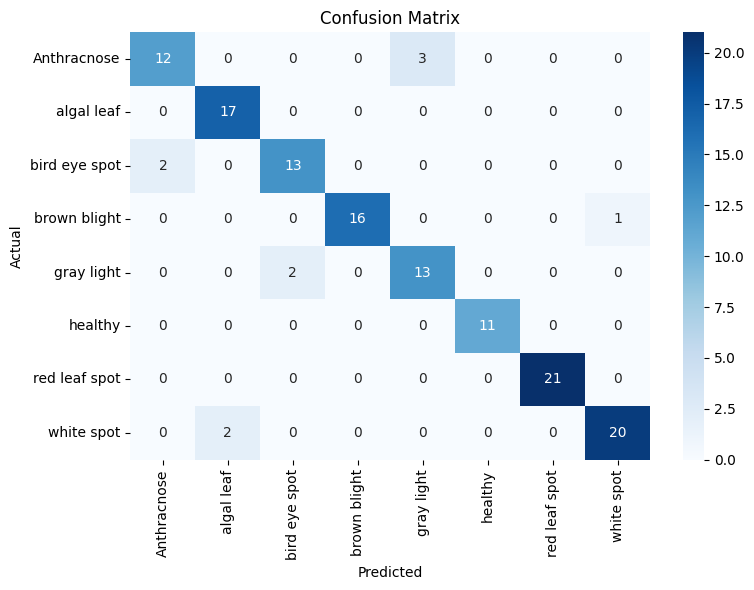

In [28]:
evaluator = Evaluator(model, val_loader, device, class_names=class_names)
metrics = evaluator.evaluate()


We achieved 94% f1-score, which is a great score since the data is not balanced.

## Save the model

In [29]:
torch.save(model, 'model.pth')

# THANK YOU